In [2]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [3]:
from dotenv import load_dotenv
import os
load_dotenv()

True

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI
model=ChatGoogleGenerativeAI(model='gemini-1.5-flash')
output=model.invoke("what is 1+2????")
print(output.content)

1 + 2 = 3


In [5]:
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
import operator

class AgentState(TypedDict):
    message: Annotated[Sequence[BaseMessage], operator.add]
    validation_passed: bool


In [8]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnablePassthrough


# Create the Tavily tool instance
tavily = TavilySearchResults()
query=""
def web_crawler_node(state: AgentState) -> AgentState:
    # Get the last user input
    print("--web crawler call--")
    query = state["message"][0].content

    # Perform real-time web search
    results = tavily.invoke(query)

    # Format search results
    if not results:
        content = "No relevant information found on the web."
    else:
        content = "\n\n".join([f"- {r['title']}: {r['content']}\n{r['url']}" for r in results])

    # Append the response as an AIMessage
    updated_messages =  [AIMessage(content=f"Tavily Search Results:\n{content}")] + list(state["message"])
    # Return the updated state
    return {
        "message": updated_messages,
        "validation_passed": state.get("validation_passed", False),  # preserve or initialize
    }

In [9]:
state: AgentState = {
    "message": [],
    "validation_passed": False
}



In [11]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
len(embeddings.embed_query("hi i am hero"))
loader=DirectoryLoader("./data",glob="./*.txt",loader_cls=TextLoader)
docs=loader.load()
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)
new_docs=text_splitter.split_documents(documents=docs)
doc_string=[doc.page_content for doc in new_docs]
db=Chroma.from_documents(new_docs,embeddings)
retriever=db.as_retriever(search_kwargs={"k": 3})
retriever.invoke("industrial growth of usa?")

[Document(metadata={'source': 'data\\usa.txt'}, page_content='Looking forward, the U.S. economy is expected to grow at a moderate pace, powered by innovation in AI, green energy, robotics, biotech, and quantum computing. The Biden administration’s Inflation'),
 Document(metadata={'source': 'data\\usa.txt'}, page_content='🇺🇸 Overview of the U.S. Economy'),
 Document(metadata={'source': 'data\\usa.txt'}, page_content='The U.S. economy remains the engine of global growth, backed by unmatched innovation, financial dominance, and a strong institutional framework. Its $28 trillion GDP and influence over global')]

In [12]:
from pydantic import BaseModel, Field  # ✅ Add this line

class TopicSelectionParser(BaseModel):
    Topic: str = Field(description="selected topic")
    Reasoning: str = Field(description="Reasoning behind topic selection")


In [13]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [14]:
def rag_node(state: AgentState) -> AgentState:
    print("-> RAG Call ->")
    question = state["message"][0].content
    prompt = PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        input_variables=['context', 'question']
    )
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return {
        "message": state["message"] + [AIMessage(content=result)],
        "validation_passed": False
    }

In [15]:
def validate_output(state: AgentState) -> AgentState:
    last_response = state["message"][-1].content
    validation_prompt = PromptTemplate.from_template("""
You are a strict validator. Is the following response factually correct, relevant, and well-structured?
Respond with only "yes" or "no".

Response:
{response}
""")
    validation_chain = validation_prompt | model | StrOutputParser()
    verdict = validation_chain.invoke({"response": last_response}).strip().lower()
    return {
        "message": state["message"],
        "validation_passed": verdict.startswith("yes")
    }




In [16]:
def function_3(state: AgentState) -> AgentState:
    print("-> LLM Call ->")
    
    # Extract the last message content (user question)
    question = state["message"][0].content

    # Prompt formulation (corrected typo in 'Answer')
    complete_query = "Answer the following question with your knowledge of the real world. Following is the user question: " + question

    # LLM invocation
    response = model.invoke(complete_query)
    # ✅ Return in AgentState format
    return {
        "message": state["message"] + [AIMessage(content=response.content)],
        "validation_passed": False  # Still needs validation
    }


In [17]:
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnableLambda
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.chat_models import ChatOpenAI

supervisor_prompt = PromptTemplate.from_template("""
You are a smart and dynamic routing assistant for an AI system.

Given a user question, decide which tool to use. You should vary your choice over time to avoid always picking the same tool:
- Use "LLM Call" for general reasoning or creative tasks.
- Use "RAG Call" when the question mentions the USA or factual past data.
- Use "Web Crawler Call" when the query needs the latest or live information.

To keep the system balanced and prevent overloading one tool, make decisions as if you're cycling through the tools intelligently.

Respond with ONLY one of these: LLM Call, RAG Call, or Web Crawler Call.

User question: {input}
Tool to use:
""")


# LLM Chain
supervisor_chain = (
    supervisor_prompt
    | model
    | StrOutputParser()
)

# Supervisor function that returns updated AgentState
def supervisor_fn(state: AgentState) -> AgentState:
    user_query = state["message"][0].content
    tool_decision = supervisor_chain.invoke({"input": user_query}).strip()

    # Create an AI message with the decision
    decision_message = AIMessage(content=f"Routing decision: {tool_decision}")
    return {
        "message": state["message"] + [decision_message],
        "validation_passed": False  # still in progress, so we mark validation as false
    }


In [18]:
def router_fn(state: AgentState) -> str:
    content = state["message"][-1].content
    if "LLM Call" in content:
        return "LLM"
    elif "RAG Call" in content:
        return "RAG"
    elif "Web Crawler" in content:
        return "Web Crawler"


In [19]:
def final_output(state: AgentState) -> AgentState:
    print("\n--- Final Output ---")
    for msg in state["message"]:
        print(f"{msg.type}: {msg.content}")
    return state

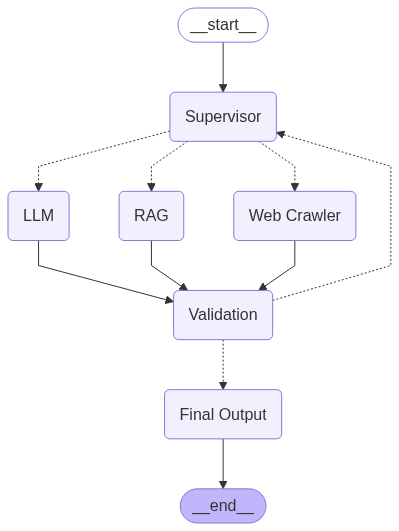

In [20]:
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage

# 1. Initialize the state graph
workflow = StateGraph(AgentState)

# 2. Add all required nodes
workflow.add_node("Supervisor", supervisor_fn)
workflow.add_node("LLM", function_3)
workflow.add_node("RAG", rag_node)
workflow.add_node("Web Crawler", web_crawler_node)
workflow.add_node("Validation", validate_output)
workflow.add_node("Final Output", final_output)

# 3. Set entry point
workflow.set_entry_point("Supervisor")

# 4. Supervisor routes based on query type
workflow.add_conditional_edges(
    "Supervisor",
    router_fn,  # should return "LLM", "RAG", or "Web Crawler"
    {
        "LLM": "LLM",
        "RAG": "RAG",
        "Web Crawler": "Web Crawler"
    }
)

# 5. After any generation, go to Validation
workflow.add_edge("LLM", "Validation")
workflow.add_edge("RAG", "Validation")
workflow.add_edge("Web Crawler", "Validation")

# 6. Validation decides whether to finalize or retry
workflow.add_conditional_edges(
    "Validation",
    lambda state: "Final Output" if state.get("validation_passed", False) else "Supervisor",
    {
        "Final Output": "Final Output",
        "Supervisor": "Supervisor"
    }
)

# 7. End the graph at Final Output
workflow.add_edge("Final Output", END)

# 8. Compile the graph
graph = workflow.compile()
graph


In [292]:
graph.invoke({
    "message": [HumanMessage(content="who is the current prime minister of india and which is heavier 5 kg cotton or 5kg iron?")],
    "validation_passed": False
})

-> LLM Call ->


-> LLM Call ->
-> LLM Call ->
-> LLM Call ->
-> LLM Call ->

--- Final Output ---
human: who is the current prime minister of india and which is heavier 5 kg cotton or 5kg iron?
human: who is the current prime minister of india and which is heavier 5 kg cotton or 5kg iron?
ai: Routing decision: LLM Call
human: who is the current prime minister of india and which is heavier 5 kg cotton or 5kg iron?
human: who is the current prime minister of india and which is heavier 5 kg cotton or 5kg iron?
ai: Routing decision: LLM Call
ai: The current Prime Minister of India is Narendra Modi.

5 kg of cotton and 5 kg of iron weigh the same: 5 kilograms.  Weight is the measure of the force of gravity on an object's mass.  While cotton takes up much more volume than iron, they both have the same mass, and therefore the same weight.
human: who is the current prime minister of india and which is heavier 5 kg cotton or 5kg iron?
human: who is the current prime minister of india and which is heavier 5 kg 

{'message': [HumanMessage(content='who is the current prime minister of india and which is heavier 5 kg cotton or 5kg iron?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='who is the current prime minister of india and which is heavier 5 kg cotton or 5kg iron?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Routing decision: LLM Call', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='who is the current prime minister of india and which is heavier 5 kg cotton or 5kg iron?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='who is the current prime minister of india and which is heavier 5 kg cotton or 5kg iron?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Routing decision: LLM Call', additional_kwargs={}, response_metadata={}),
  AIMessage(content="The current Prime Minister of India is Narendra Modi.\n\n5 kg of cotton and 5 kg of iron weigh the same: 5 kilograms.  Weight is the measu